## 1. PREPROCESS DATA



In [59]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
tf.random.set_seed(142)

2.6.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [60]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow_addons as tfa
from tensorflow_addons.metrics import FBetaScore 

import tqdm.notebook as tq
import os
import logging
import warnings
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

### 1.2 Explore Dataset

In [61]:
proj_fold = '../input/planets-dataset/planet'
data_path = os.path.join(proj_fold, "planet")
train_jpg_dir = os.path.join(data_path, 'train-jpg')
train_csv_path = os.path.join(data_path , "train_classes.csv")

In [62]:
df = pd.read_csv(train_csv_path)
df.head(5)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [63]:
dummies = df['tags'].str.get_dummies(' ')
df = pd.concat([df, dummies], axis=1)

labels = dummies.columns.values
unique_val= len(labels)
dummies

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40474,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40475,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40476,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40477,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0


In [64]:
print(f"There are {n_labels} unique labels including {labels}")

There are 17 unique labels including ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [65]:
# Countplot of label distribution
label_count = dummies.sum(axis=0).sort_values()
print(label_count)

blow_down               98
conventional_mine      100
slash_burn             209
blooming               332
artisinal_mine         339
selective_logging      340
bare_ground            862
cloudy                2089
haze                  2697
habitation            3660
cultivation           4477
partly_cloudy         7261
water                 7411
road                  8071
agriculture          12315
clear                28431
primary              37513
dtype: int64


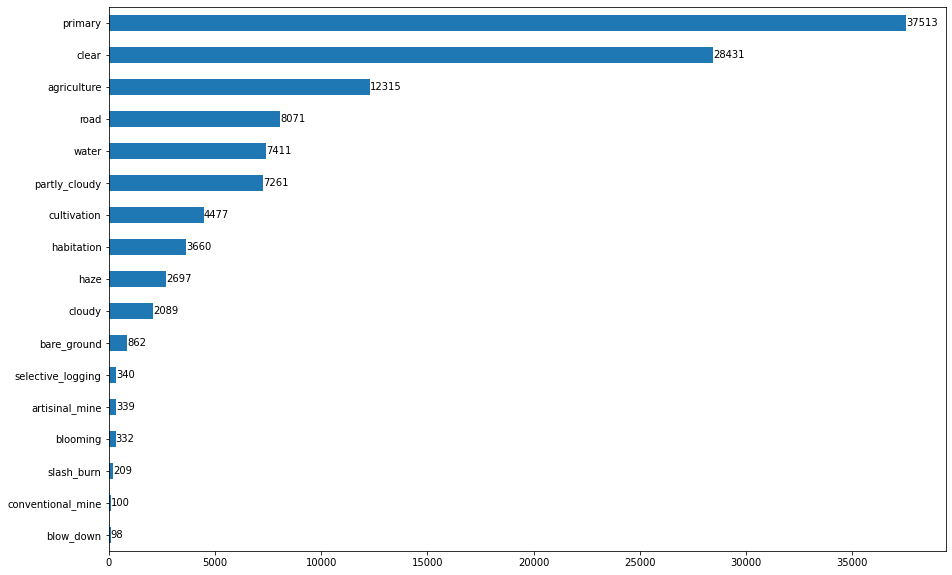

In [66]:
label_count.plot(kind='barh', figsize=(15, 10))
for i in range(label_count.shape[0]):
    plt.text(label_count.iloc[i] + 4, i, label_count.iloc[i], va='center')

In [67]:
images_title = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' for i, label in enumerate(labels)]

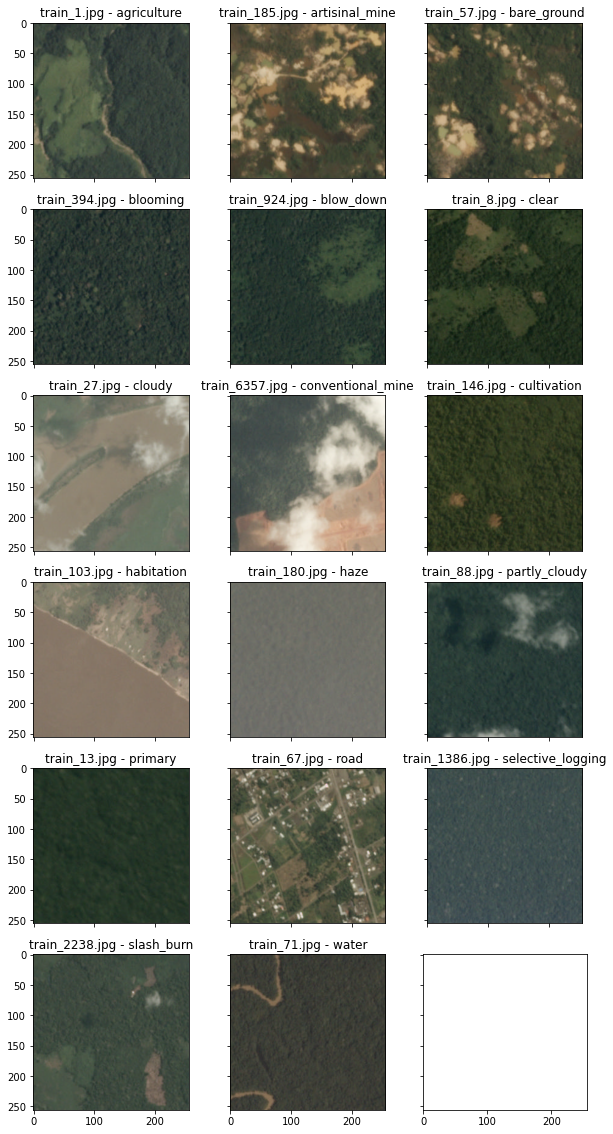

In [68]:
_, axs = plt.subplots(6, 3, sharex='col', sharey='row', figsize=(10, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels)):
    img_path = os.path.join(train_jpg_dir, image_name)
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(f'{image_name} - {label}')

In [69]:
pip install iterative-stratification

Note: you may need to restart the kernel to use updated packages.


In [70]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [71]:
y = df[labels].values
X = df['image_name'].values

df['fold'] = np.nan

mskf = MultilabelStratifiedKFold(n_splits=5)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    df.iloc[test_index, -1] = i
   
df['fold'] = df['fold'].astype('int')
df['is_valid'] = False
df['is_valid'][df['fold'] == 0] = True

In [72]:
# Number of observations of each tags in each fold. 
df.groupby('fold')[labels].sum()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
fold,,,,,,,,,,,,,,,,,
0,2463,68,172,66,20,5687,418,20,896,732,539,1452,7491,1614,68,41,1482
1,2463,67,173,66,19,5686,418,20,895,732,540,1452,7493,1614,68,42,1482
2,2463,68,172,67,19,5686,418,20,896,732,539,1452,7503,1615,68,42,1482
3,2463,68,173,67,20,5686,418,20,895,732,539,1453,7504,1614,68,42,1483
4,2463,68,172,66,20,5686,417,20,895,732,540,1452,7522,1614,68,42,1482


In [73]:
train_size = df.shape[0] - df['is_valid'].sum()
val_size = df['is_valid'].sum()

### 1.4. Export raw data to TFRecords

In [74]:
# Converting the values into features

def _image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def _int64_feature(value):
    if type(value) != list:
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array


def image_feature(path, label):
    image = plt.imread(path)

    # image = tf.io.decode_jpeg(image, channels=3)
    feature = {'height': _int64_feature(image.shape[0]),
               'width': _int64_feature(image.shape[1]),
               'channel': _int64_feature(image.shape[2]),
               'image': _bytes_feature(serialize_array(image)),
               'label': _int64_feature(label),}
    return tf.train.Example(features=tf.train.Features(feature=feature))


def create_record(df, folder_path, record_name):
    all_image_paths = df['image_name'].apply(lambda x: os.path.join(train_jpg_dir, x+'.jpg')).values
    all_labels = df[labels].values

    record_path = os.path.join(f"./{record_name}.tfrecords")
    writer = tf.io.TFRecordWriter(record_path) 

    for i in tq.tqdm(range(df.shape[0])):
        path = all_image_paths[i]
        label = all_labels[i].tolist()
        example = image_feature(path, label)
        writer.write(example.SerializeToString())
    
    writer.close()


In [75]:
# for i in range(5): 
#     create_record(df[df['fold'] == i], DATA_PATH, f'fold_{i}')

### 1.5 Load data from TFRecord

In [76]:
#arch
records = tf.io.gfile.glob(str('../input/tf-records-files/*.tfrecords'))
records

['../input/tf-records-files/fold_3.tfrecords',
 '../input/tf-records-files/fold_1.tfrecords',
 '../input/tf-records-files/fold_4.tfrecords',
 '../input/tf-records-files/fold_2.tfrecords',
 '../input/tf-records-files/fold_0 .tfrecords']

In [77]:
IMG_WIDTH, IMG_HEIGHT = 224,224
CHANNELS = 3

def read_tfrecord(example):
    tfrecord_format = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "channel": tf.io.FixedLenFeature([], tf.int64),
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([17], tf.int64, default_value=np.zeros((17,)).astype('int').tolist())
    }
    example = tf.io.parse_single_example(example, tfrecord_format)

    # Extract information
    height = example['height']
    width = example['width']
    channel = example['channel']
    image = example['image']
    label = example['label']

    # Convert raw image back to array
    image = tf.io.parse_tensor(image, out_type=tf.uint8)
    image = tf.reshape(image, shape=[height, width, channel])
    if channel == 4:
        image = image[:,:,:3]

    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])

    return (image, label)

In [78]:
batch_size = 64
shuffle_buffer_size = 1024
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [79]:
def augmentation(image, label):
    image = tf.image.random_brightness(image, .1)
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

def load_dataset(filenames, shuffle=False, augment=False):
    """Load a list of pahts of TFRecords 
       and split them into train and validation set."""

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

    # dataset = dataset.cache()

    if shuffle == True:
        dataset = dataset.shuffle(buffer_size = shuffle_buffer_size).repeat()

    if augment == True:
        dataset.map(augmentation, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [80]:
records

['../input/tf-records-files/fold_3.tfrecords',
 '../input/tf-records-files/fold_1.tfrecords',
 '../input/tf-records-files/fold_4.tfrecords',
 '../input/tf-records-files/fold_2.tfrecords',
 '../input/tf-records-files/fold_0 .tfrecords']

In [81]:
train_ds = load_dataset(records[:4], shuffle=True, augment=True)
val_ds = load_dataset(records[4], shuffle=False, augment=False)

In [82]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, None), (None, 17)), types: (tf.float32, tf.int64)>

In [83]:
val_ds

<PrefetchDataset shapes: ((None, 224, 224, None), (None, 17)), types: (tf.float32, tf.int64)>

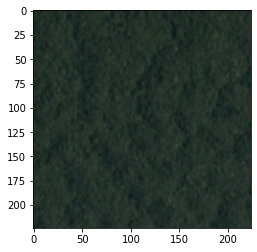

In [84]:
for i in train_ds.take(1):
    plt.imshow(i[0][1].numpy() / 255.)
    plt.show()

In [85]:
sample = df[df['fold'] == 0]
sample.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,...,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water,fold,is_valid
17,train_17,partly_cloudy primary,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,True
19,train_19,agriculture clear primary road,1,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,True
21,train_21,clear primary road water,0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,True
22,train_22,partly_cloudy primary,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,True
23,train_23,agriculture clear primary road,1,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,True


In [86]:
sample[labels].sum() / df[labels].sum()

agriculture          0.200000
artisinal_mine       0.200590
bare_ground          0.199536
blooming             0.198795
blow_down            0.204082
clear                0.200028
cloudy               0.200096
conventional_mine    0.200000
cultivation          0.200134
habitation           0.200000
haze                 0.199852
partly_cloudy        0.199972
primary              0.199691
road                 0.199975
selective_logging    0.200000
slash_burn           0.196172
water                0.199973
dtype: float64

## 2. MODELLING

In [87]:
def amazon_deforestation_model(trainable = False, fine_tune_at = 0):
    
    mobile_net = tf.keras.applications.MobileNetV3Large(input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), include_top=False)
    if trainable == True:
        mobile_net.trainable=True
    
        for layer in mobile_net.layers[:fine_tune_at]:
            layer.trainable = False
    else: 
        mobile_net.trainable = False
        
    
    input = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS), name='input')
    x = tf.keras.applications.mobilenet_v3.preprocess_input(input)
    x = mobile_net(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(unique_val, activation = 'sigmoid')(x)
    model = tf.keras.Model(input, output)
    return model

In [88]:
model = amazon_deforestation_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 1024)        1311744   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 17)                17425     
Total params: 5,555,601
Trainable params: 1,329,169
Non-trainable params: 4,226,432
_________________________________________________________________


In [89]:
for batch in train_ds: 
    print(model.predict(batch[0]))
    break

2022-03-22 17:33:01.563031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


[[0.47015336 0.52136797 0.3556737  ... 0.54892683 0.58905286 0.4281507 ]
 [0.51286614 0.43703264 0.39050698 ... 0.54433733 0.54622245 0.41631457]
 [0.5624837  0.62775123 0.32965252 ... 0.454592   0.46585384 0.44732696]
 ...
 [0.50242615 0.7856995  0.63634986 ... 0.44041416 0.5018745  0.36974403]
 [0.54481536 0.5349147  0.50743276 ... 0.5395451  0.46676442 0.5545202 ]
 [0.48586372 0.28606984 0.4809719  ... 0.60010564 0.56740797 0.5547325 ]]


In [93]:
es_patience = 5
rlrop_patience = 3
decay_drop = 0.5

In [94]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [102]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=es_patience, restore_best_weights=True, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=rlrop_patience, factor=decay_drop, min_lr=1e-6, verbose=1)

cp_callback = [early_stop, lr_decay]

In [103]:
LR = 1e-5
EPOCHS = 50
num_steps_train = tf.math.ceil(float(train_size)/batch_size)              
num_steps_val = tf.math.ceil(float(val_size)/batch_size)

fbeta = FBetaScore(num_classes=n_labels,
                   average='weighted',
                   beta=2.0,
                   threshold=0.2,
                   name='fbeta')

In [104]:
# Compile model with optimizer
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
               loss = 'binary_crossentropy',
               metrics = [fbeta, tf.keras.metrics.AUC()])

In [105]:
# Train model
history = model.fit(train_ds,
                  steps_per_epoch = num_steps_train,
                  epochs = EPOCHS,
                  validation_data = val_ds,
                  validation_steps = num_steps_val,
                  callbacks=[cp_callback, lr_decay], verbose = 2)

Epoch 1/50
506/506 - 91s - loss: 0.0894 - fbeta: 0.9130 - auc_1: 0.9898 - val_loss: 0.0986 - val_fbeta: 0.9015 - val_auc_1: 0.9872
Epoch 2/50
506/506 - 95s - loss: 0.0891 - fbeta: 0.9135 - auc_1: 0.9899 - val_loss: 0.0985 - val_fbeta: 0.9013 - val_auc_1: 0.9872
Epoch 3/50
506/506 - 95s - loss: 0.0888 - fbeta: 0.9136 - auc_1: 0.9900 - val_loss: 0.0984 - val_fbeta: 0.9017 - val_auc_1: 0.9872

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 4/50
506/506 - 95s - loss: 0.0885 - fbeta: 0.9141 - auc_1: 0.9901 - val_loss: 0.0983 - val_fbeta: 0.9021 - val_auc_1: 0.9872
Epoch 5/50
506/506 - 93s - loss: 0.0883 - fbeta: 0.9142 - auc_1: 0.9901 - val_loss: 0.0982 - val_fbeta: 0.9021 - val_auc_1: 0.9873

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 6/50
506/506 - 98s - loss: 0.0880 - fbeta: 0.9145 - auc_1: 0.9901 - val_loss: 0.0982 - val_fbeta: 0.9022 - val_auc_1: 0.9873
Epoch 7/50
506/506 - 88s - loss: 0.0880 - fbeta: 0.9

In [106]:
 def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

<Figure size 1080x720 with 0 Axes>

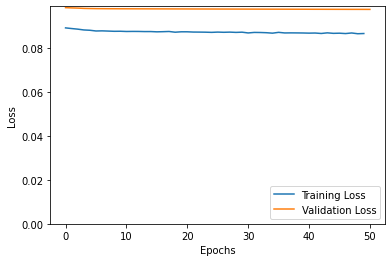

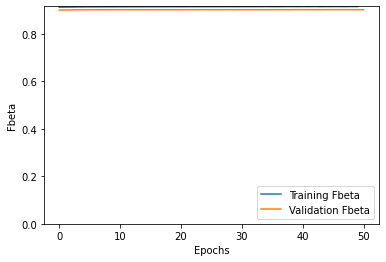

In [107]:
plt.figure(figsize = (15, 10))

plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['fbeta'], history.history['val_fbeta'], x_label='Epochs', stats='fbeta');

In [108]:
SAVE_PATH = '/kaggle/working/model/1_full_decay.h5'
model.save(SAVE_PATH)

In [109]:
model = tf.keras.models.load_model(SAVE_PATH)

In [110]:
def read_tfrecord_label_only(example):
    tfrecord_format = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "channel": tf.io.FixedLenFeature([], tf.int64),
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([17], tf.int64, default_value=np.zeros((17,)).astype('int').tolist())
    }
    example = tf.io.parse_single_example(example, tfrecord_format)

    # Extract information
    height = example['height']
    width = example['width']
    channel = example['channel']
    image = example['image']
    label = example['label']

    return label

In [111]:
train_label_ds = tf.data.TFRecordDataset(records[:4])
train_label_ds = train_label_ds.map(read_tfrecord_label_only, num_parallel_calls=AUTOTUNE)

In [112]:
true = list(train_label_ds.as_numpy_iterator())
true = np.array(true)
true.shape

(32364, 17)

In [113]:
train_image_ds = load_dataset(records[:4], shuffle=False, augment=False)

In [114]:
predictions = model.predict(train_image_ds)
final_predictions = (predictions > 0.2).astype('int')
final_predictions.shape

(32364, 17)

In [115]:
from sklearn.metrics import fbeta_score
fbeta_score(true, final_predictions, average='weighted', beta=2)

0.9159278647272306

In [116]:
from sklearn.metrics import classification_report
print(classification_report(true, final_predictions))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82      9852
           1       0.77      0.85      0.81       271
           2       0.49      0.43      0.46       689
           3       0.25      0.14      0.18       265
           4       0.80      0.05      0.10        79
           5       0.92      0.99      0.95     22725
           6       0.71      0.94      0.80      1671
           7       0.71      0.64      0.67        80
           8       0.47      0.78      0.59      3582
           9       0.57      0.82      0.67      2928
          10       0.59      0.85      0.69      2158
          11       0.82      0.95      0.88      5809
          12       0.96      1.00      0.98     30011
          13       0.72      0.92      0.81      6457
          14       0.41      0.33      0.37       272
          15       0.41      0.05      0.10       167
          16       0.67      0.88      0.76      5929

   micro avg       0.81   

In [117]:
for data in train_image_ds.take(1):
    sample_images = data[0].numpy().astype('int')
    sample_labels = data[1].numpy().astype('bool')

sample_images = sample_images[:40]
sample_labels = sample_labels[:40]
sample_predictions = final_predictions[:40]

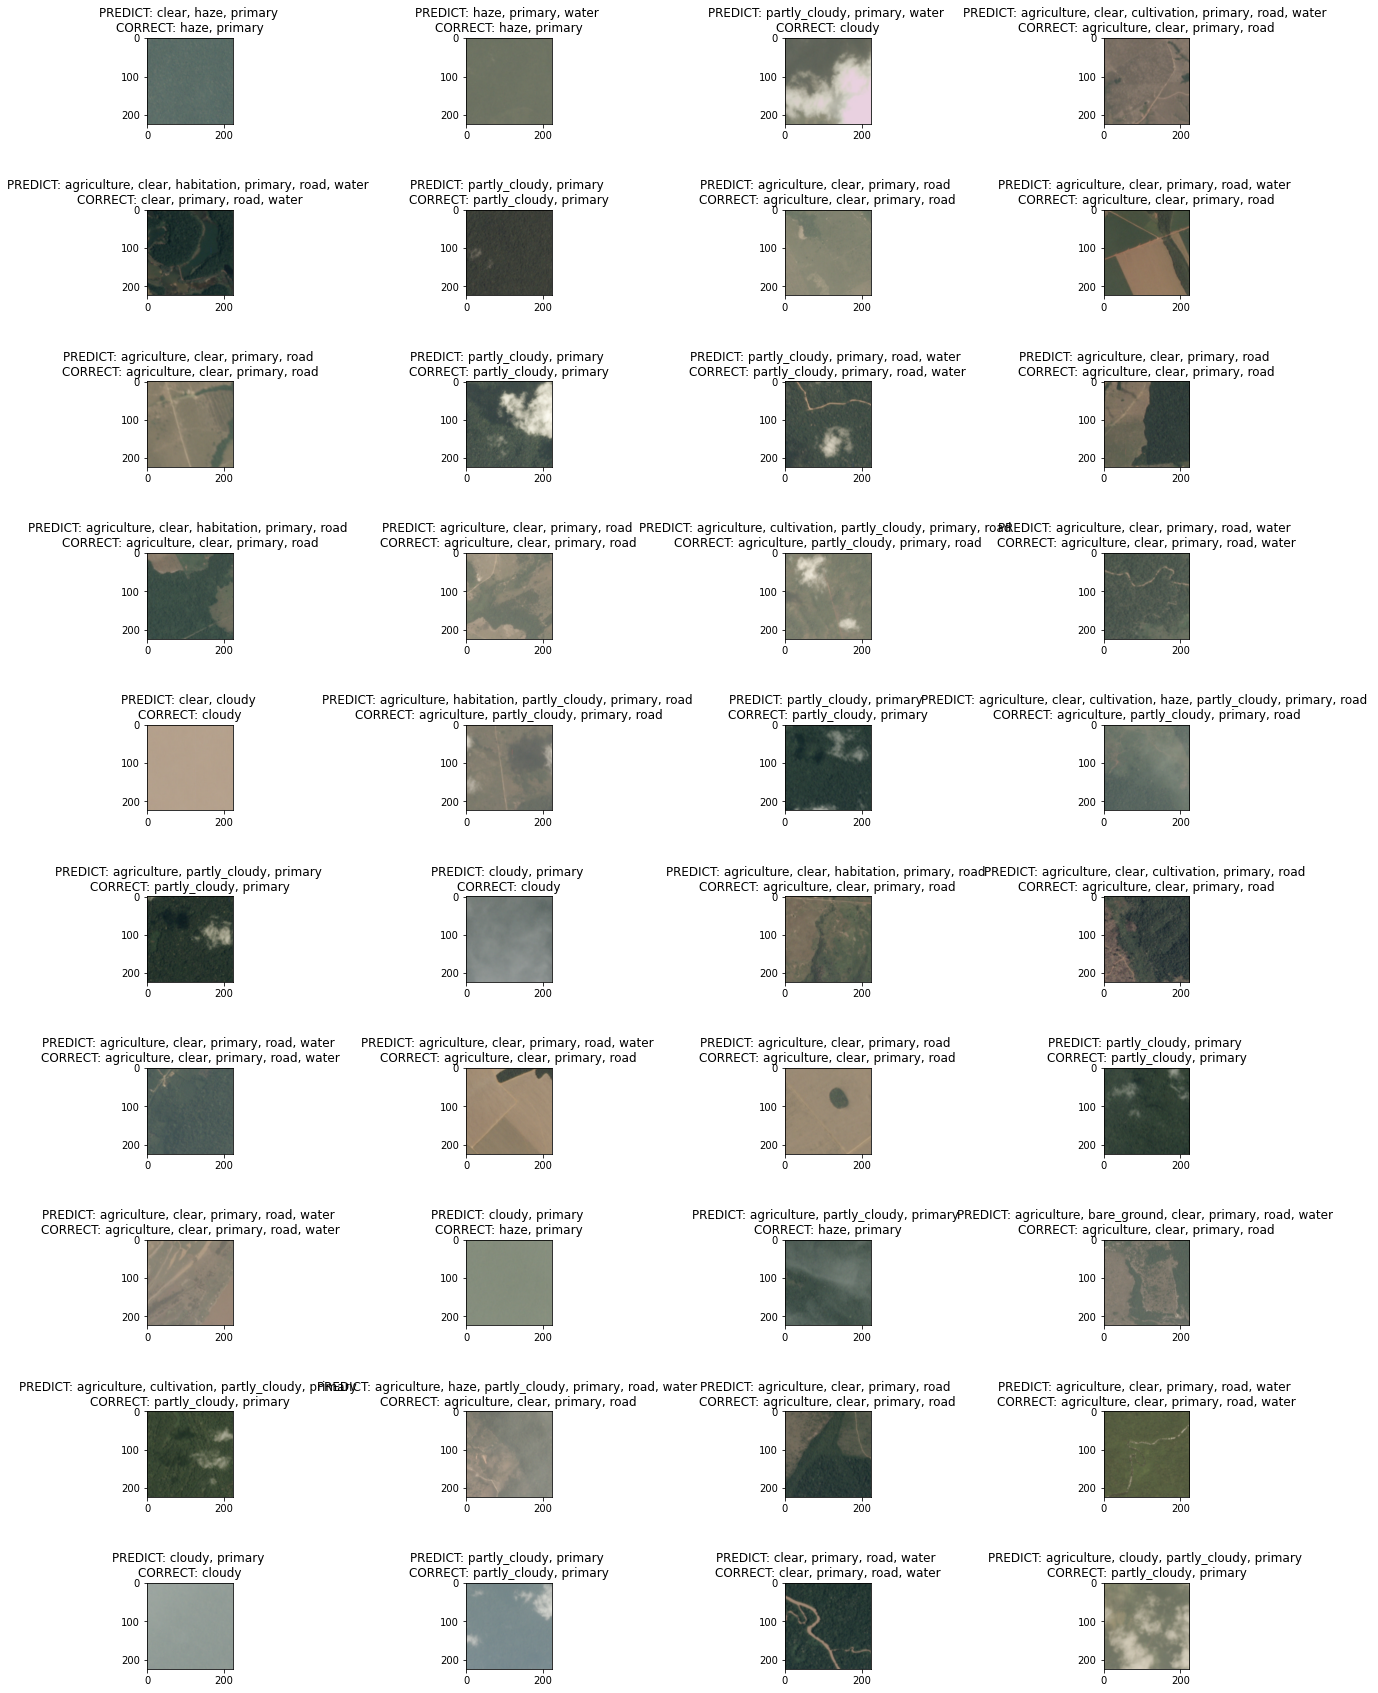

In [118]:
fig, axes = plt.subplots(10, 4, figsize=(20, 30))
axes = axes.ravel()

for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    axes[i].imshow(image)
    predict_label = labels[sample_predictions[i] == 1]
    predict_label = ', '.join(predict_label)
    correct = ', '.join(labels[label])
    axes[i].set_title(f"PREDICT: {predict_label} \nCORRECT: {correct}")

plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

## 3. TUNING THRESHOLD

In [119]:
def perf_grid(y_hat_val, y_val, label_names, n_thresh=100):
    
    # Find label frequencies in the validation set
    label_freq = y_val.sum(axis=0)

    # Define thresholds
    thresholds = np.linspace(0, 1, n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s, f2s = [], [], [], [], [], [], [], [], [], []
    
    for i in tq.tqdm(range(len(label_names))):
        for thresh in thresholds:   
            ids.append(i)
            labels.append(label_names[i])
            freqs.append(round(label_freq[i]/len(y_val),2))

            y = y_val[:, i]
            y_pred = y_hat_val[:, i] > thresh

            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            f2 = fbeta_score(y, y_pred, average='weighted', beta=2)
            
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            f2s.append(f2)
            
    # Create the performance dataframe
    grid = pd.DataFrame({'id':ids,
                         'label':labels,
                         'freq':freqs,
                         'threshold':list(thresholds)*len(label_names),
                         'tp':tps,
                         'fp':fps,
                         'fn':fns,
                         'precision':precisions,
                         'recall':recalls,
                         'f1':f1s,
                         'f2': f2s})
    
    return grid

In [120]:
predictions.shape

(32364, 17)

In [121]:
true.shape

(32364, 17)

In [122]:
# Performance table
grid = perf_grid(predictions, true, labels)

  0%|          | 0/17 [00:00<?, ?it/s]

In [123]:
grid[grid['label'].str.contains('primary')].head(20)

,id,label,freq,threshold,tp,fp,fn,precision,recall,f1,f2
1212,12,primary,0.93,0.00,30011,2353,0,0.927296,1.000000,0.962277,0.912979
1213,12,primary,0.93,0.01,30011,2239,0,0.930574,1.000000,0.964038,0.918013
1214,12,primary,0.93,0.02,30010,2063,1,0.935678,0.999967,0.966755,0.925560
1215,12,primary,0.93,0.03,30007,1936,4,0.939392,0.999867,0.968686,0.930803
1216,12,primary,0.93,0.04,30005,1822,6,0.942753,0.999800,0.970439,0.935426
1217,12,primary,0.93,0.05,30000,1739,11,0.945209,0.999633,0.971660,0.938641
1218,12,primary,0.93,0.06,30000,1681,11,0.946940,0.999633,0.972573,0.940952
1219,12,primary,0.93,0.07,29997,1627,14,0.948552,0.999534,0.973376,0.943002
1220,12,primary,0.93,0.08,29994,1572,17,0.950200,0.999434,0.974195,0.945072
1221,12,primary,0.93,0.09,29990,1511,21,0.952033,0.999300,0.975094,0.947325


In [124]:
# Choose the best threshold of 
grid_max = grid.loc[grid.groupby(['id', 'label'])[['f2']].idxmax()['f2'].values]
grid_max

,id,label,freq,threshold,tp,fp,fn,precision,recall,f1,f2
47,0,agriculture,0.30,0.47,8388,1482,1464,0.849848,0.851401,0.850624,0.908982
127,1,artisinal_mine,0.01,0.26,226,55,45,0.804270,0.833948,0.818841,0.996921
233,2,bare_ground,0.02,0.31,204,97,485,0.677741,0.296081,0.412121,0.980433
341,3,blooming,0.01,0.38,12,14,253,0.461538,0.045283,0.082474,0.990358
419,4,blow_down,0.00,0.15,7,4,72,0.636364,0.088608,0.155556,0.997277
558,5,clear,0.70,0.53,22010,960,715,0.958206,0.968537,0.963344,0.948152
655,6,cloudy,0.05,0.49,1370,259,301,0.841007,0.819868,0.830303,0.982653
733,7,conventional_mine,0.00,0.26,46,6,34,0.884615,0.575000,0.696970,0.998698
849,8,cultivation,0.11,0.41,1827,794,1755,0.697062,0.510050,0.589070,0.918704
957,9,habitation,0.09,0.48,1718,368,1210,0.823586,0.586749,0.685281,0.949372


## 4. PREDICT ON TEST 

In [125]:
test_paths = tf.io.gfile.glob(str(data_path + '/test-jpg/*.jpg')) 
additional_paths = tf.io.gfile.glob(str('../input/planets-dataset/test-jpg-additional' + '/test-jpg-additional/*.jpg')) 

In [126]:
def create_test_record(data_folder, record_name):
    paths = tf.io.gfile.glob(str(data_folder + f'/{record_name}/*.jpg')) 

    record_path = f"./{record_name}.tfrecords"
    writer = tf.io.TFRecordWriter(record_path) 

    for i in tq.tqdm(range(len(paths))):
        path = paths[i]
        image = plt.imread(path)
        feature = {'height': _int64_feature(image.shape[0]),
                   'width': _int64_feature(image.shape[1]),
                   'channel': _int64_feature(image.shape[2]),
                   'image': _bytes_feature(serialize_array(image))}
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())
    writer.close()

In [127]:
create_test_record(data_path,'test-jpg')
create_test_record("../input/planets-dataset/test-jpg-additional",'test-jpg-additional')

  0%|          | 0/40669 [00:00<?, ?it/s]

  0%|          | 0/20522 [00:00<?, ?it/s]

In [128]:
def read_test_record(example): 
    tfrecord_format = {
            "height": tf.io.FixedLenFeature([], tf.int64),
            "width": tf.io.FixedLenFeature([], tf.int64),
            "channel": tf.io.FixedLenFeature([], tf.int64),
            "image": tf.io.FixedLenFeature([], tf.string)
            }

    example = tf.io.parse_single_example(example, tfrecord_format)

    # Extract information
    height = example['height']
    width = example['width']
    channel = example['channel']
    image = example['image']

    # Convert raw image back to array
    image = tf.io.parse_tensor(image, out_type=tf.uint8)
    image = tf.reshape(image, shape=[height, width, channel])
    if channel == 4:
        image = image[:,:,:3]

    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    return image

In [132]:
def load_test_dataset(filenames, shuffle=False, augment=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_test_record, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [133]:
RECORDS = tf.io.gfile.glob('./*.tfrecords')
RECORDS

['./test-jpg.tfrecords', './test-jpg-additional.tfrecords']

In [134]:
test_ds = load_test_dataset(RECORDS[-2])
additional_ds = load_test_dataset(RECORDS[-1])

In [135]:
test_predictions = model.predict(test_ds)
additional_predictions = model.predict(additional_ds)

In [136]:
len(test_predictions)

40669

In [137]:
threshold = { 'agriculture':0.164,
          'artisinal_mine':0.114,
          'bare_ground':0.138,
          'blooming':0.168,
          'blow_down':0.2,
          'clear':0.13,
          'cloudy':0.076,   
          'conventional_mine':0.1,
          'cultivation':0.204,
          'habitation':0.17,
          'haze':0.204,
          'partly_cloudy':0.112,
          'primary':0.204,
          'road':0.156,
          'selective_logging':0.154,
          'slash_burn':0.38,
          'water':0.182
            }
            
thresholds = np.fromiter(threshold.values(), dtype=float)

In [138]:
def get_tag(prediction):
    return ' '.join(labels[(prediction >= thresholds)])

final_test_predictions = list(map(get_tag, test_predictions))
final_additional_predictions = list(map(get_tag, additional_predictions))

In [139]:
len(final_test_predictions)

40669

In [140]:
test_filenames = list(map(lambda x: x.split('/')[-1][:-4], test_paths))
additional_filenames = list(map(lambda x: x.split('/')[-1][:-4], additional_paths))

In [141]:
submission = pd.DataFrame({'image_name': test_filenames, 'tags': final_test_predictions})
submission['count'] = submission['image_name'].str.strip('test_').astype('int')
submission = submission.sort_values('count', ascending=True).reset_index(drop=True)
submission.drop(columns=['count'], inplace=True)
submission

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear partly_cloudy primary
4,test_4,cloudy partly_cloudy primary
...,...,...
40664,test_40664,clear primary
40665,test_40665,agriculture clear cultivation primary water
40666,test_40666,agriculture clear cultivation partly_cloudy pr...
40667,test_40667,partly_cloudy primary water


In [142]:
submission_2 = pd.DataFrame({'image_name': additional_filenames, 'tags': final_additional_predictions})
submission_2['count'] = submission_2['image_name'].str.strip('file_').astype('int')
submission_2 = submission_2.sort_values('count', ascending=True).reset_index(drop=True)
submission_2.drop(columns=['count'], inplace=True)
submission_2

,image_name,tags
0,file_0,clear primary
1,file_1,agriculture cultivation partly_cloudy primary ...
2,file_2,agriculture clear primary
3,file_3,agriculture clear primary water
4,file_4,agriculture cultivation partly_cloudy primary ...
...,...,...
20517,file_20517,clear primary
20518,file_20518,partly_cloudy primary
20519,file_20519,agriculture clear primary road water
20520,file_20520,agriculture clear cultivation primary road


In [143]:
final_submission = pd.concat([submission, submission_2], axis=0)
final_submission

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear partly_cloudy primary
4,test_4,cloudy partly_cloudy primary
...,...,...
20517,file_20517,clear primary
20518,file_20518,partly_cloudy primary
20519,file_20519,agriculture clear primary road water
20520,file_20520,agriculture clear cultivation primary road


In [144]:
final_submission.to_csv("final_submission_2_time.csv", index=False)